# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
from sympy.printing.pytorch import torch
from torch import nn
from pytorch_tcn import TCN 
import time
import cv2
import mediapipe as mp
import numpy as np
import os


In [ ]:
#from mmpose.apis import init_model, inference_topdown
#from mmpose.structures import merge_data_samples
#from mmpose.visualization import PoseLocalVisualizer

In [8]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "squat_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "squat_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)
            #extend kullanılmasının sebebi listedeki elemanları tek tek ekler
            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1764001671.139477  749178 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1764001671.222062  773112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764001671.240877  773114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.8036316    0.52076638  -1.13567066 ... 101.04884824 138.91949709
   90.55514148]
 [  0.79494649   0.71028262  -0.48349556 ...  87.1460867  131.70982977
  131.32925987]
 [  0.79389513   0.65686965  -0.66779006 ...  74.64284034 133.21121774
  102.4636605 ]
 ...
 [ -0.19844148   0.65654701  -0.66112423 ...  77.98145881 111.77033105
   11.43569217]
 [ -0.2481163    0.6195817   -0.32425445 ...  16.54034642  46.90112282
   56.01465319]
 [ -0.27616078   0.79702914  -0.19934031 ...   5.15478759  51.35013837
   44.93596327]]
videoplayback-8.mp4 için veri kaydedildi -> squat_dataset/videoplayback-8.npy
Veri kaydedildi: [[ 9.62019935e-02  4.85099971e-01 -1.13490753e-01 ...  1.52427076e+02
   1.46785508e+02  8.56005505e+01]
 [ 9.66007933e-02  4.85181808e-01 -1.59541845e-01 ...  1.54023813e+02
   1.33643948e+02  6.78255843e+01]
 [ 9.65965912e-02  4.86103088e-01 -1.45711839e-01 ...  1.53595149e+02
   1.37473082e+02  7.28670378e+01]
 ...
 [ 8.58854502e-02  5.26235759e-01 -1.121

In [9]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)


#BU CELL VİDEODAN ŞINAV DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "pushup_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "pushup_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]
            left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].z]

            # Açılar
            elbow_angel=calculate_angle(left_shoulder,left_elbow,left_hip)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)

            keypoints.extend([elbow_angel, knee_angle,])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #boş listeyse 102 tane 0 yaz değilse sonra frame ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1764002526.751690  749178 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1764002526.840519  785297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764002526.857952  785299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.48033455   0.82065254  -0.256515   ...   0.58623415  91.72430498
  178.02704238]
 [  0.48071387   0.82292145  -0.26389912 ...   0.52113825  85.94223449
  178.54080182]
 [  0.48073962   0.82369679  -0.26658288 ...   0.51038593  84.48316388
  178.79784792]
 ...
 [  0.49918717   0.84481996  -0.27613062 ...   0.53693116  95.79998858
  175.75870548]
 [  0.49918717   0.84481996  -0.27613062 ...   0.53693116  95.79998858
  175.75870548]
 [  0.49918717   0.84481996  -0.27613062 ...   0.53693116  95.79998858
  175.75870548]]
IMG_6137.mp4 için veri kaydedildi -> pushup_dataset/IMG_6137.npy
Veri kaydedildi: [[ 4.55328077e-01  8.21577847e-01 -1.12824492e-01 ...  3.77014279e-01
   9.51068013e+01  1.76911253e+02]
 [ 4.53648061e-01  8.18992078e-01 -8.21425244e-02 ...  4.23187941e-01
   1.02282570e+02  1.74825184e+02]
 [ 4.52186584e-01  8.16274107e-01 -7.61361420e-02 ...  4.46985364e-01
   1.00741175e+02  1.74310512e+02]
 ...
 [ 4.59076345e-01  8.27935755e-01 -1.60411552e-01 ...

In [3]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "jumpingjack_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "jumpingjack_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302291.346590 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302291.456228 3367674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302291.477202 3367675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302291.520217 3367677 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Veri kaydedildi: [[ 2.87781447e-01  4.52091426e-01 -1.46413535e-01 ...  1.29710303e+02
   1.38937931e+02  8.11575385e+01]
 [ 2.92657167e-01  4.49336350e-01 -1.68035254e-01 ...  1.30576295e+02
   1.36532442e+02  8.48514500e+01]
 [ 2.99057513e-01  4.48729724e-01 -1.77278265e-01 ...  1.31665298e+02
   1.32334590e+02  7.87874324e+01]
 ...
 [ 2.42563814e-01  5.12554348e-01 -1.60567209e-01 ...  1.40787973e+02
   1.62384611e+02  8.40132744e+01]
 [ 2.42563814e-01  5.12554348e-01 -1.60567209e-01 ...  1.40787973e+02
   1.62384611e+02  8.40132744e+01]
 [ 2.42563814e-01  5.12554348e-01 -1.60567209e-01 ...  1.40787973e+02
   1.62384611e+02  8.40132744e+01]]
IMG_6335.mp4 için veri kaydedildi -> jumpingjack_dataset/IMG_6335.npy
Veri kaydedildi: [[ 3.02935958e-01  4.26879138e-01 -2.37338603e-01 ...  1.38091229e+02
   1.35735526e+02  8.16179817e+01]
 [ 3.05101544e-01  4.18538690e-01 -2.67730623e-01 ...  1.46733230e+02
   1.32808852e+02  7.41663334e+01]
 [ 2.99213499e-01  4.22717214e-01 -2.43712142e-01 

In [4]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "dizcekme_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "dizcekme_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302333.714620 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302333.790891 3368295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302333.806164 3368295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[ 1.56558707e-01  4.02751923e-01 -1.29338473e-01 ...  1.51746669e+02
   1.50749907e+02  7.22911790e+01]
 [ 1.55314744e-01  4.02679443e-01 -1.07325025e-01 ...  1.54776320e+02
   1.49475000e+02  7.04271528e+01]
 [ 1.54454067e-01  4.02571410e-01 -1.03981636e-01 ...  1.55619221e+02
   1.49016379e+02  6.95041413e+01]
 ...
 [ 1.35868400e-01  3.96592468e-01 -9.11405161e-02 ...  1.58189070e+02
   1.53083890e+02  6.93974678e+01]
 [ 1.35868400e-01  3.96592468e-01 -9.11405161e-02 ...  1.58189070e+02
   1.53083890e+02  6.93974678e+01]
 [ 1.35868400e-01  3.96592468e-01 -9.11405161e-02 ...  1.58189070e+02
   1.53083890e+02  6.93974678e+01]]
IMG_6424.mp4 için veri kaydedildi -> dizcekme_dataset/IMG_6424.npy
Veri kaydedildi: [[ 1.40145794e-01  4.43449229e-01 -7.62544125e-02 ...  1.59747907e+02
   1.49967700e+02  8.19410523e+01]
 [ 1.43310681e-01  4.54745352e-01 -4.90694381e-02 ...  1.52487571e+02
   1.44527246e+02  7.92327934e+01]
 [ 1.44454718e-01  4.52147812e-01 -1.86442528e-02 ...

In [5]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "plank_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "plank_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302379.968318 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302380.043558 3368876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302380.060479 3368876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.48115376   0.48891148  -0.64769733 ... 167.02221442 170.50158214
  154.59874231]
 [  0.50268918   0.50318491  -0.8068037  ... 165.68516157 168.62051622
  159.37148843]
 [  0.50626922   0.51013446  -0.83453864 ... 166.14247664 169.52892697
  156.92643013]
 ...
 [  0.5351364    0.48710525  -0.26430884 ... 111.13370466 149.71607646
  120.17763576]
 [  0.5351364    0.48710525  -0.26430884 ... 111.13370466 149.71607646
  120.17763576]
 [  0.5351364    0.48710525  -0.26430884 ... 111.13370466 149.71607646
  120.17763576]]
IMG_6321.mp4 için veri kaydedildi -> plank_dataset/IMG_6321.npy
Veri kaydedildi: [[ 5.34474194e-01  6.07424438e-01  3.37710567e-02 ...  6.01748189e+01
   1.28710596e+02  1.23712568e+02]
 [ 5.42896271e-01  6.41442716e-01  3.17999385e-02 ...  4.72930358e+01
   1.20046410e+02  1.18729318e+02]
 [ 5.47657847e-01  6.55257523e-01 -1.68341979e-01 ...  5.10917155e+01
   1.04077893e+02  1.00932888e+02]
 ...
 [ 5.57564616e-01  7.55196452e-01 -3.28621924e-01 ... 

In [6]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "sideplank_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "sideplank_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302452.860661 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302452.941769 3369717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302452.959510 3369720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.57895017   0.70205098  -0.50670171 ... 175.72931051 166.57995136
   78.02500789]
 [  0.5802356    0.70058233  -0.56439847 ... 175.85114551 165.64213655
   72.33474407]
 [  0.58101535   0.70059127  -0.59466976 ... 176.92084668 165.703622
   69.86645815]
 ...
 [  0.58290905   0.71482956  -0.46889156 ... 172.89266168 171.88312859
   74.02422218]
 [  0.58290905   0.71482956  -0.46889156 ... 172.89266168 171.88312859
   74.02422218]
 [  0.58290905   0.71482956  -0.46889156 ... 172.89266168 171.88312859
   74.02422218]]
IMG_6395.mp4 için veri kaydedildi -> sideplank_dataset/IMG_6395.npy
Veri kaydedildi: [[  0.53415006   0.88263977  -0.3072238  ... 139.8426105  112.22519022
   75.47292313]
 [  0.53025228   0.89180028  -0.26446792 ... 159.3441691  124.64819844
   75.41646168]
 [  0.52988899   0.89482212  -0.27768698 ... 160.50290116 123.9912967
   71.96510855]
 ...
 [  0.53148401   0.89206982  -0.28072634 ... 167.64107625 136.07114987
   70.22617844]
 [  0.53148401   0.8

In [7]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "dagcitirmanis_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "dagcitirmanis_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302475.477363 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302475.558251 3370153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302475.575394 3370153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[ 5.13693571e-01  1.49584800e-01 -5.40261902e-03 ...  8.96380969e+01
   1.02560340e+02  1.44234017e+02]
 [ 5.13851106e-01  1.49204761e-01 -6.23182487e-03 ...  1.15416179e+02
   1.28808481e+02  1.04491004e+02]
 [ 5.13020039e-01  1.49426609e-01 -8.12619086e-03 ...  1.20178211e+02
   1.36645887e+02  9.45274048e+01]
 ...
 [ 5.29713035e-01  9.06941295e-02 -6.44414797e-02 ...  1.51223934e+02
   1.71286367e+02  7.26468290e+01]
 [ 5.29713035e-01  9.06941295e-02 -6.44414797e-02 ...  1.51223934e+02
   1.71286367e+02  7.26468290e+01]
 [ 5.29713035e-01  9.06941295e-02 -6.44414797e-02 ...  1.51223934e+02
   1.71286367e+02  7.26468290e+01]]
IMG_6381.mp4 için veri kaydedildi -> dagcitirmanis_dataset/IMG_6381.npy
Veri kaydedildi: [[ 5.11625111e-01  8.67945850e-01 -3.92444991e-02 ...  1.62271196e+02
   1.71809428e+02  6.71091363e+01]
 [ 5.11295140e-01  8.68008733e-01 -4.97527644e-02 ...  1.64377080e+02
   1.70796594e+02  6.16706553e+01]
 [ 5.11186004e-01  8.68037820e-01 -6.19018748e-0

In [8]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "lung_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "lung_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302520.497917 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302520.573180 3370641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302520.589903 3370640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[ 1.41076878e-01  4.96562600e-01 -1.13177299e-01 ...  1.47068184e+02
   1.58309977e+02  1.09189860e+02]
 [ 1.42660722e-01  4.92488563e-01 -9.86425430e-02 ...  1.47653697e+02
   1.56792836e+02  1.08425643e+02]
 [ 1.43510252e-01  4.89834934e-01 -9.67298374e-02 ...  1.47481600e+02
   1.53707773e+02  1.05693656e+02]
 ...
 [ 1.33194864e-01  4.65630174e-01 -1.16146408e-01 ...  1.38843590e+02
   1.57999083e+02  1.10665249e+02]
 [ 1.33194864e-01  4.65630174e-01 -1.16146408e-01 ...  1.38843590e+02
   1.57999083e+02  1.10665249e+02]
 [ 1.33194864e-01  4.65630174e-01 -1.16146408e-01 ...  1.38843590e+02
   1.57999083e+02  1.10665249e+02]]
IMG_6356.mp4 için veri kaydedildi -> lung_dataset/IMG_6356.npy
Veri kaydedildi: [[  0.20769286   0.56423998  -0.16258129 ... 144.55670199 145.61099615
   65.48327862]
 [  0.22050923   0.56790298  -0.15663101 ... 140.41227399 138.12064001
   58.26570562]
 [  0.22693004   0.57720381  -0.15743954 ... 141.14917267 140.91251427
   56.58609841]
 ...
 

In [5]:
import os
import numpy as np

CLASS_DIRS = {
    "squat": "squat_dataset",
    "pushup": "pushup_dataset",
    "dagcitirmanis": "dagcitirmanis_dataset",
    "jumpingjack": "jumpingjack_dataset",
    #"lunge": "lung_dataset",
    "plank": "plank_dataset",
    "sideplank": "sideplank_dataset",
    "dizcekme": "dizcekme_dataset"
}


def load_datasets(class_dirs):
    X = []
    y = []

    # Feature dim'i ilk sınıfın ilk dosyasından al
    first_class_dir = list(class_dirs.values())[0]
    sample_files = [f for f in os.listdir(first_class_dir) if f.endswith(".npy")]

    if len(sample_files) == 0:
        raise ValueError("İlk dataset boş")

    sample_data = np.load(os.path.join(first_class_dir, sample_files[0]), allow_pickle=True)

    if isinstance(sample_data, list):
        sample_data = np.array(sample_data, dtype=np.float32)

    feature_dim = sample_data.shape[1]

    def process_file(file_path, class_id):
        data = np.load(file_path, allow_pickle=True)

        if isinstance(data, list):
            data = np.array(data, dtype=np.float32)

        if data.dtype == object:
            data = np.array(
                [np.array(frame, dtype=np.float32) for frame in data],
                dtype=np.float32
            )

        # 200 frame şartı
        if data.shape[0] != 200:
            print("Atlandı (frame != 200):", file_path)
            return

        # Feature padding / cutting
        if data.shape[1] < feature_dim:
            pad_width = feature_dim - data.shape[1]
            padding = np.zeros((200, pad_width), dtype=np.float32)
            data = np.hstack([data, padding])
        elif data.shape[1] > feature_dim:
            data = data[:, :feature_dim]

        X.append(data)
        y.append(class_id)

    # Tüm sınıfları dolaş
    for class_id, (class_name, class_dir) in enumerate(class_dirs.items()):
        print(f"Yükleniyor: {class_name} -> label {class_id}")

        for f in os.listdir(class_dir):
            if f.endswith(".npy"):
                process_file(os.path.join(class_dir, f), class_id)

    X_arr = np.stack(X, axis=0)
    y_arr = np.array(y, dtype=np.int32)

    return X_arr, y_arr


X, y = load_datasets(CLASS_DIRS)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Kaydet
np.save("dataset_X.npy", X)
np.save("dataset_y.npy", y)

print("Dataset kaydedildi.")


Yükleniyor: squat -> label 0
Yükleniyor: pushup -> label 1
Yükleniyor: dagcitirmanis -> label 2
Yükleniyor: jumpingjack -> label 3
Yükleniyor: plank -> label 4
Yükleniyor: sideplank -> label 5
Yükleniyor: dizcekme -> label 6
X shape: (150, 200, 102)
y shape: (150,)
Dataset kaydedildi.


In [2]:
X = np.load("dataset_X.npy")
y = np.load("dataset_y.npy")
print("X shape:", X.shape)
print("y shape:", y.shape)

X = X.astype("float32")
#sayılar büyük olmadığından minik bir normalizasyon yapar
X = X / np.max(X)


X shape: (150, 200, 102)
y shape: (150,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=y   # sınıf dengesini korur
)


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

#!!!!kernel density estination yöntemi ile eğitim yapılacak!!!!!

class PoseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
train_dataset = PoseDataset(X_train, y_train)
test_dataset=PoseDataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=8, shuffle=False)
    

In [5]:

#hidden dim modelin öğrenebileceği özellik sayısıdır
#num_layers içeride kaç katman olacağını belirtir
class LSTMModel(nn.Module):
    def __init__(self, input_dim=102, hidden_dim=128, num_layers=2, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last timestep
        return self.fc(out)

In [6]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=102, hidden_dim=128, num_layers=2, num_classes=2):
        super().__init__()
        #HİDDEN DİM KAÇ FARKLI ÖZELLİK ÖĞRENECEĞİ
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [15]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN  # doğru import

class PoseTCN(nn.Module):
    def __init__(self, input_size=102, num_classes=2):
        super(PoseTCN, self).__init__()

        # Tek katmanlı TCN (TCN liste istiyor!)
        self.tcn = TCN(
            num_inputs=input_size,
            #HER FİLTRE İLE FARKLI ÖZELLİKLER ÖĞRENİR 64 ADET FİLTRE İLE FARKLI ÖZZELLİKLER
            num_channels=[64],  # HATA BURADAYDI → liste olması gerek
            kernel_size=5,
            dropout=0.2
        )

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x = (batch, seq_len, features) → (batch, features, seq_len)
        x = x.transpose(1, 2)
        out = self.tcn(x)       # (batch, out_channels, seq_len)
        out = out[:, :, -1]     # son zaman adımı
        return self.fc(out)


In [5]:
import sys
sys.path.append('/Users/tahay/Documents/pytorch/modular')  
import train_utils

In [24]:
model_old = PoseTCN(input_size=102, num_classes=8)

criterion_old = nn.CrossEntropyLoss()

optimizer_old = torch.optim.Adam(
    model_old.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_old = torch.optim.lr_scheduler.StepLR(
    optimizer_old, step_size=10, gamma=0.9
)

train_losses_0, train_accs_0, val_losses_0, val_accs_0 = train_utils.train_multi_class_model(
    model_old,
    train_loader,
    test_loader,
    loss=criterion_old,
    optimizer=optimizer_old,
    scheduler=scheduler_old,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

np.save("before_train_loss.npy", train_losses_0)
np.save("before_train_acc.npy", train_accs_0)
np.save("before_val_loss.npy", val_losses_0)
np.save("before_val_acc.npy", val_accs_0)



Epoch [1/50]
Train Loss: 2.0811, Train Acc: 14.29%
Val Loss: 2.0726, Val Acc: 27.78%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/50]
Train Loss: 2.0700, Train Acc: 25.00%
Val Loss: 2.0645, Val Acc: 27.78%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/50]
Train Loss: 2.0601, Train Acc: 25.00%
Val Loss: 2.0500, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/50]
Train Loss: 2.0415, Train Acc: 24.29%
Val Loss: 2.0275, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/50]
Train Loss: 2.0116, Train Acc: 25.00%
Val Loss: 1.9801, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/50]
Train Loss: 1.9532, Train Acc: 27.14%
Val Loss: 1.8898, Val Acc: 30.56%
Learning Rate: 0.000

In [27]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN  # doğru import

class PoseTCN_1(nn.Module):
    def __init__(self, input_size=102, num_classes=2):
        super(PoseTCN_1, self).__init__()

        # Tek katmanlı TCN (TCN liste istiyor!)
        self.tcn = TCN(
            num_inputs=input_size,
            num_channels=[64, 128, 128],
            kernel_size=5,
            dropout=0.3
        )

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x = (batch, seq_len, features) → (batch, features, seq_len)
        x = x.transpose(1, 2)
        out = self.tcn(x)       # (batch, out_channels, seq_len)
        #SADECE SON ZAMAN ADIMI YERİNE TÜM ZAMAN ADIMLARINI ORTALAMA ALIYORUZ
        out = torch.mean(out, dim=2)   # (B, C)
        return self.fc(out)


In [29]:
model_old_1 = PoseTCN_1(input_size=102, num_classes=8)

criterion_old_1 = nn.CrossEntropyLoss()

optimizer_old_1 = torch.optim.Adam(
    model_old_1.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_old_1 = torch.optim.lr_scheduler.StepLR(
    optimizer_old_1, step_size=15, gamma=0.8
)

train_losses_1, train_accs_1, val_losses_1, val_accs_1 = train_utils.train_multi_class_model(
    model_old_1,
    train_loader,
    test_loader,
    loss=criterion_old_1,
    optimizer=optimizer_old_1,
    scheduler=scheduler_old_1,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

np.save("before_train_loss_1.npy", train_losses_1)
np.save("before_train_acc_1.npy", train_accs_1)
np.save("before_val_loss_1.npy", val_losses_1)
np.save("before_val_acc_1.npy", val_accs_1)



Epoch [1/50]
Train Loss: 2.0833, Train Acc: 12.14%
Val Loss: 2.0416, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/50]
Train Loss: 2.0045, Train Acc: 28.57%
Val Loss: 1.8984, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/50]
Train Loss: 1.8131, Train Acc: 31.43%
Val Loss: 1.6481, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/50]
Train Loss: 1.6220, Train Acc: 34.29%
Val Loss: 1.5758, Val Acc: 44.44%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/50]
Train Loss: 1.5879, Train Acc: 34.29%
Val Loss: 1.4957, Val Acc: 44.44%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/50]
Train Loss: 1.5309, Train Acc: 36.43%
Val Loss: 1.5287, Val Acc: 27.78%
Learning Rate: 0.000

In [2]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN  # doğru import

class PoseTCN_2(nn.Module):
    def __init__(self, input_size=102, num_classes=2):
        super(PoseTCN_2, self).__init__()
        # Tek katmanlı TCN (TCN liste istiyor!)
        self.tcn = TCN(
            num_inputs=input_size,
            num_channels=[64, 128, 256],
            kernel_size=5,
            dropout=0.4
        )
        #HEM MEAN HEM MAX KULLANIDĞIMZDAN 256*2
        self.fc = nn.Linear(256 * 2, num_classes)
    def forward(self, x):
        # x: (B, T, F) → (B, F, T)
        x = x.transpose(1, 2)
        out = self.tcn(x)          # (B, 256, T)
        #TÜM ZAMAN ORTALAMASI
        mean_pool = torch.mean(out, dim=2)       # (B, 256)
        #EN YÜKSEK DEĞERLERE GÖRE POOLING
        max_pool = torch.max(out, dim=2)[0]      # (B, 256)
        out = torch.cat([mean_pool, max_pool], dim=1)  # (B, 512)
        return self.fc(out)   



In [9]:
model_old_2 = PoseTCN_2(input_size=102, num_classes=8)

criterion_old_2 = nn.CrossEntropyLoss()

optimizer_old_2 = torch.optim.Adam(
    model_old_2.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_old_2 = torch.optim.lr_scheduler.StepLR(
    optimizer_old_2, step_size=15, gamma=0.8
)

train_losses_2, train_accs_2, val_losses_2, val_accs_2 = train_utils.train_multi_class_model(
    model_old_2,
    train_loader,
    test_loader,
    loss=criterion_old_2,
    optimizer=optimizer_old_2,
    scheduler=scheduler_old_2,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TCN_2"
)

np.save("before_train_loss_2.npy", train_losses_2)
np.save("before_train_acc_2.npy", train_accs_2)
np.save("before_val_loss_2.npy", val_losses_2)
np.save("before_val_acc_2.npy", val_accs_2)



NameError: name 'train_utils' is not defined

Confusion Matrix:
[[4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0]
 [0 0 1 0 0 1 1 0]
 [0 0 0 4 0 0 0 0]
 [0 0 0 0 5 0 0 0]
 [0 0 0 0 0 2 3 0]
 [0 0 0 1 0 1 2 0]
 [0 0 0 2 0 0 0 3]]
Class 0 accuracy: 100.00%
Class 1 accuracy: 100.00%
Class 2 accuracy: 33.33%
Class 3 accuracy: 100.00%
Class 4 accuracy: 100.00%
Class 5 accuracy: 40.00%
Class 6 accuracy: 50.00%
Class 7 accuracy: 60.00%
Squat: 100.00%
Pushup: 100.00%
DagTirmanis: 33.33%
JumpingJack: 100.00%
Lunge: 100.00%
Plank: 40.00%
SidePlank: 50.00%
DizCekme: 60.00%


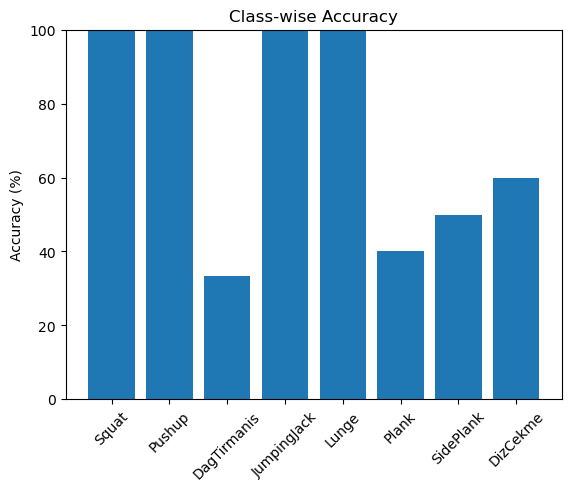

In [33]:
#SONUÇLARI GÖRSELLEŞTİRME
import torch
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model_old_2(X)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

from sklearn.metrics import confusion_matrix

num_classes = 8  # senin sınıf sayın
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
print("Confusion Matrix:")
print(cm)

class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"Class {i} accuracy: {acc*100:.2f}%")


class_names = [
    "Squat",
    "Pushup",
    "DagTirmanis",
    "JumpingJack",
    "Lunge",
    "Plank",
    "SidePlank",
    "DizCekme"
]

for name, acc in zip(class_names, class_accuracy):
    print(f"{name}: {acc*100:.2f}%")

import matplotlib.pyplot as plt

plt.figure()
plt.bar(class_names, class_accuracy * 100)
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()



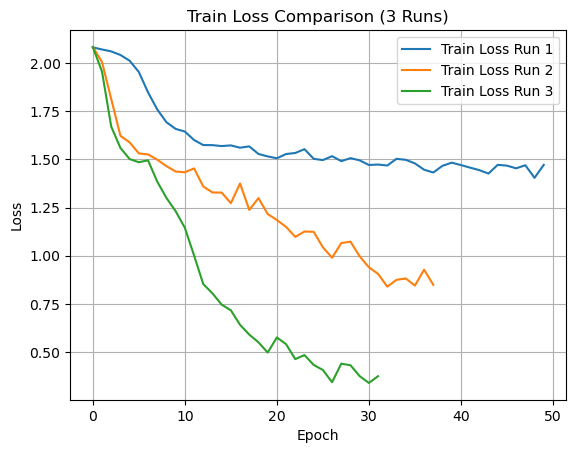

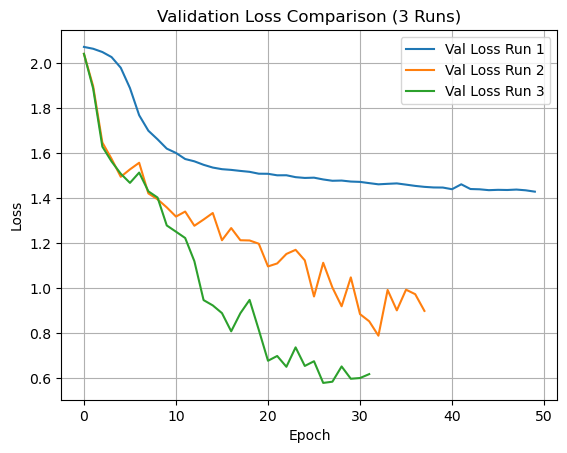

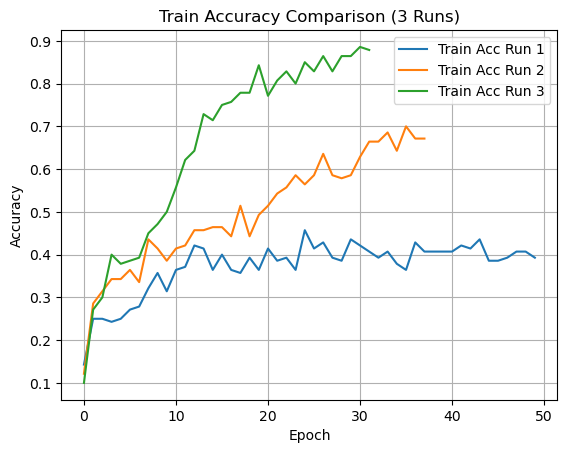

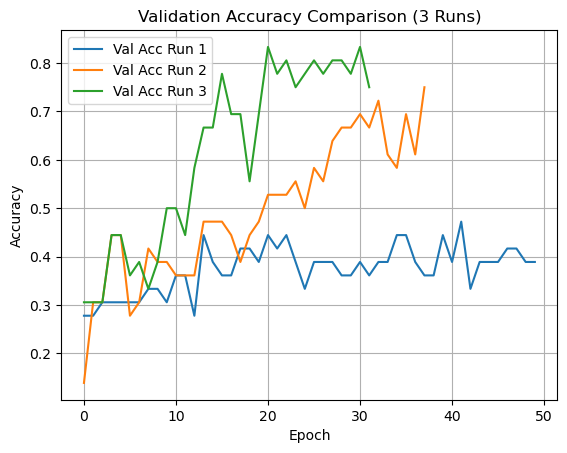

In [34]:
#SONUÇLARI GÖRSELLEŞTİRME
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DOSYA SUFFIX'LERİ
# -----------------------
suffixes = ["", "_1", "_2"]

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# -----------------------
# LOAD DATA
# -----------------------
for s in suffixes:
    train_losses.append(np.load(f"before_train_loss{s}.npy"))
    val_losses.append(np.load(f"before_val_loss{s}.npy"))
    train_accs.append(np.load(f"before_train_acc{s}.npy"))
    val_accs.append(np.load(f"before_val_acc{s}.npy"))

# -----------------------
# TRAIN LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(train_losses):
    plt.plot(loss, label=f"Train Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(val_losses):
    plt.plot(loss, label=f"Val Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# TRAIN ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(train_accs):
    plt.plot(acc, label=f"Train Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(val_accs):
    plt.plot(acc, label=f"Val Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
###!!!!!!ONE-HOT EKLENMİŞ ADIM !!!!!

In [11]:
model_new_1 = PoseTCN_2(input_size=102, num_classes=8)

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

criterion_new_1 = nn.BCEWithLogitsLoss()

optimizer_new_1 = torch.optim.Adam(
    model_new_1.parameters(),
    lr=0.0003,
    weight_decay=1e-4
)

scheduler_new_1 = torch.optim.lr_scheduler.StepLR(
    optimizer_new_1, step_size=15, gamma=0.8
)

new_train_losses_1 , new_train_accs_1 , new_val_losses_1 , new_val_accs_1 =  train_utils.train_multi_class_one_hot(
    model_new_1,
    train_loader,
    test_loader,
    loss=criterion_new_1,
    optimizer=optimizer_new_1,
    scheduler=scheduler_new_1,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TCN_One_Hot_NOLunge"
)

np.save("new_train_loss_1.npy", new_train_losses_1)
np.save("new_train_acc_1.npy", new_train_accs_1)
np.save("new_val_loss_1.npy", new_val_losses_1)
np.save("new_val_acc_1.npy", new_val_accs_1)


Epoch [1/50]
Train Loss: 0.5115 | Train Acc: 9.17%
Val   Loss: 0.3708 | Val   Acc: 13.33%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [2/50]
Train Loss: 0.3794 | Train Acc: 19.17%
Val   Loss: 0.4303 | Val   Acc: 20.00%
LR: 0.000300
--------------------------------------------------
Epoch [3/50]
Train Loss: 0.3533 | Train Acc: 27.50%
Val   Loss: 0.3891 | Val   Acc: 33.33%
LR: 0.000300
--------------------------------------------------
Epoch [4/50]
Train Loss: 0.3286 | Train Acc: 32.50%
Val   Loss: 0.3511 | Val   Acc: 33.33%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [5/50]
Train Loss: 0.2840 | Train Acc: 39.17%
Val   Loss: 0.3189 | Val   Acc: 50.00%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [6/50]
Train Loss: 0.2693 | Train Acc: 42.50%
Val   Loss: 0.3058 | Val   Acc: 46.67%
LR: 0.000300
--------------------------------------------------
✅ Best m

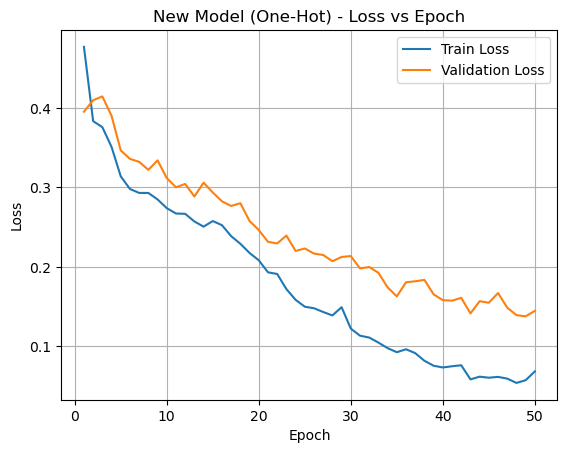

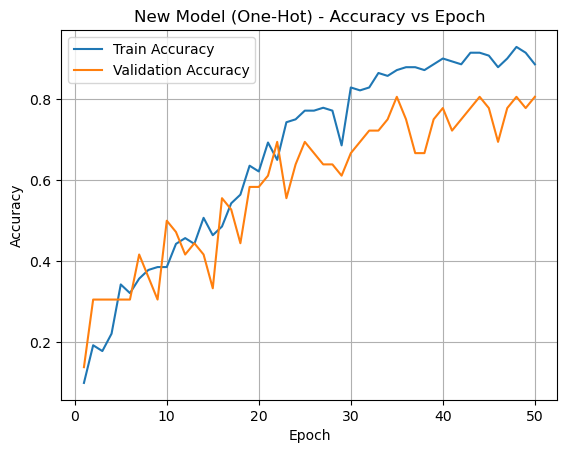

In [12]:
#SONUÇLARI GÖRSELLEŞTİRME
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# LOAD DATA
# -----------------------
train_loss = np.load("new_train_loss_1.npy")
val_loss   = np.load("new_val_loss_1.npy")
train_acc  = np.load("new_train_acc_1.npy")
val_acc    = np.load("new_val_acc_1.npy")

epochs = range(1, len(train_loss) + 1)

# -----------------------
# LOSS
# -----------------------
plt.figure()
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("New Model (One-Hot) - Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# ACCURACY
# -----------------------
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("New Model (One-Hot) - Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
[[4 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0]
 [0 0 1 0 0 2 0 0]
 [0 0 0 2 0 0 2 0]
 [0 0 0 0 5 0 0 0]
 [0 0 0 0 0 3 2 0]
 [0 0 1 0 0 0 3 0]
 [0 0 0 0 0 0 0 5]]
Squat: 100.00%
Pushup: 100.00%
DagTirmanis: 33.33%
JumpingJack: 50.00%
Lunge: 100.00%
Plank: 60.00%
SidePlank: 75.00%
DizCekme: 100.00%


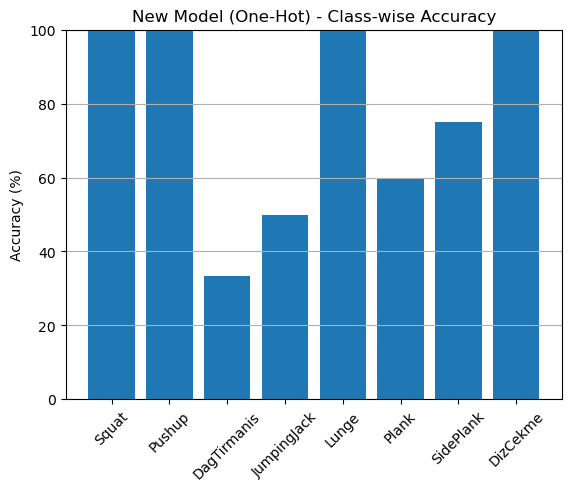

In [13]:
#SONUÇLARI GÖRSELLEŞTİRME

import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model_new_1.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)           # y = integer label (B,)

        logits = model_new_1(X)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


from sklearn.metrics import confusion_matrix

num_classes = 8
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
print("Confusion Matrix:")
print(cm)

class_acc = cm.diagonal() / cm.sum(axis=1)

class_names = [
    "Squat",
    "Pushup",
    "DagTirmanis",
    "JumpingJack",
    "Lunge",
    "Plank",
    "SidePlank",
    "DizCekme"
]

for name, acc in zip(class_names, class_acc):
    print(f"{name}: {acc*100:.2f}%")

import matplotlib.pyplot as plt

plt.figure()
plt.bar(class_names, class_acc * 100)
plt.ylabel("Accuracy (%)")
plt.title("New Model (One-Hot) - Class-wise Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()



In [14]:
model_new_2 = BiLSTMModel(input_dim=102, hidden_dim=64, num_layers=2, num_classes=8)



criterion_new_2 = nn.BCEWithLogitsLoss()
optimizer_new_2 = torch.optim.Adam(model_new_2.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_2 = torch.optim.lr_scheduler.StepLR(optimizer_new_2, step_size=15, gamma=0.8)

new_train_losses_2 , new_train_accs_2,new_val_losses_2,new_val_accs_2 = train_utils.train_multi_class_one_hot(
    model_new_2,
    train_loader,
    test_loader,
    loss=criterion_new_2,
    optimizer=optimizer_new_2,
    scheduler=scheduler_new_2,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="BiLSTM_One_Hot"
)

np.save("new_train_loss_2.npy", new_train_losses_2)
np.save("new_train_acc_2.npy", new_train_accs_2)
np.save("new_val_loss_2.npy", new_val_losses_2)
np.save("new_val_acc_2.npy", new_val_accs_2)



Epoch [1/50]
Train Loss: 0.6685 | Train Acc: 9.29%
Val   Loss: 0.6498 | Val   Acc: 11.11%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [2/50]
Train Loss: 0.6249 | Train Acc: 10.71%
Val   Loss: 0.5778 | Val   Acc: 13.89%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [3/50]
Train Loss: 0.4987 | Train Acc: 13.57%
Val   Loss: 0.4065 | Val   Acc: 16.67%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [4/50]
Train Loss: 0.3836 | Train Acc: 17.14%
Val   Loss: 0.3752 | Val   Acc: 16.67%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [5/50]
Train Loss: 0.3754 | Train Acc: 17.14%
Val   Loss: 0.3757 | Val   Acc: 16.67%
LR: 0.000300
--------------------------------------------------
Epoch [6/50]
Train Loss: 0.3746 | Train Acc: 17.14%
Val   Loss: 0.3750 | Val   Acc: 16.67%
LR: 0.000300
--------------------------------------

In [16]:
model_new_3 = BiLSTMModel(input_dim=102, hidden_dim=64, num_layers=2, num_classes=8)



criterion_new_3= nn.CrossEntropyLoss()
optimizer_new_3 = torch.optim.Adam(model_new_3.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_3 = torch.optim.lr_scheduler.StepLR(optimizer_new_3, step_size=15, gamma=0.8)

new_train_losses_3 , new_train_accs_3,new_val_losses_3,new_val_accs_3 = train_utils.train_multi_class_model(
    model_new_3,
    train_loader,
    test_loader,
    loss=criterion_new_3,
    optimizer=optimizer_new_3,
    scheduler=scheduler_new_3,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="BiLSTM_Model"
)

np.save("new_train_loss_3.npy", new_train_losses_3)
np.save("new_train_acc_3.npy", new_train_accs_3)
np.save("new_val_loss_3.npy", new_val_losses_3)
np.save("new_val_acc_3.npy", new_val_accs_3)



Epoch [1/50]
Train Loss: 2.0831, Train Acc: 15.00%
Val Loss: 2.0771, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/50]
Train Loss: 2.0764, Train Acc: 15.00%
Val Loss: 2.0719, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/50]
Train Loss: 2.0698, Train Acc: 15.00%
Val Loss: 2.0680, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/50]
Train Loss: 2.0645, Train Acc: 18.57%
Val Loss: 2.0606, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/50]
Train Loss: 2.0505, Train Acc: 27.14%
Val Loss: 2.0424, Val Acc: 16.67%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/50]
Train Loss: 2.0071, Train Acc: 17.86%
Val Loss: 1.9421, Val Acc: 30.56%
Learning Rate: 0.000

In [17]:
import torch
import torch.nn as nn

class BiLSTMImproved(nn.Module):
    def __init__(
        self,
        input_dim=102,
        hidden_dim=64,
        num_layers=2,
        num_classes=8,
        dropout=0.3
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # bidirectional olduğu için hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        #x: (batch_size, seq_len, feature_dim)
        out, _ = self.lstm(x)          # (B, T, 2*H)
        # 🔥 Temporal mean pooling
        out = torch.mean(out, dim=1)   # (B, 2*H)
        return self.fc(out)            # (B, num_classes)


In [18]:
model_new_4 = BiLSTMImproved(input_dim=102, hidden_dim=64, num_layers=2, num_classes=8,dropout=0.3)



criterion_new_4= nn.CrossEntropyLoss()
optimizer_new_4 = torch.optim.Adam(model_new_4.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_4 = torch.optim.lr_scheduler.StepLR(optimizer_new_4, step_size=15, gamma=0.8)

new_train_losses_4 , new_train_accs_4,new_val_losses_4,new_val_accs_4 = train_utils.train_multi_class_model(
    model_new_4,
    train_loader,
    test_loader,
    loss=criterion_new_4,
    optimizer=optimizer_new_4,
    scheduler=scheduler_new_4,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="ImprovedBiLSTM_Model"
)

np.save("new_train_loss_4.npy", new_train_losses_4)
np.save("new_train_acc_4.npy", new_train_accs_4)
np.save("new_val_loss_4.npy", new_val_losses_4)
np.save("new_val_acc_4.npy", new_val_accs_4)



Epoch [1/50]
Train Loss: 2.0835, Train Acc: 13.57%
Val Loss: 2.0747, Val Acc: 27.78%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/50]
Train Loss: 2.0723, Train Acc: 18.57%
Val Loss: 2.0684, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/50]
Train Loss: 2.0634, Train Acc: 17.14%
Val Loss: 2.0598, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/50]
Train Loss: 2.0524, Train Acc: 31.43%
Val Loss: 2.0472, Val Acc: 27.78%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/50]
Train Loss: 2.0307, Train Acc: 27.86%
Val Loss: 2.0169, Val Acc: 30.56%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/50]
Train Loss: 1.9557, Train Acc: 28.57%
Val Loss: 1.8283, Val Acc: 36.11%
Learning Rate: 0.000

In [20]:
model_new_5 = LSTMModel(input_dim=102, hidden_dim=64, num_layers=2, num_classes=8)



criterion_new_5= nn.CrossEntropyLoss()
optimizer_new_5 = torch.optim.Adam(model_new_5.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_5 = torch.optim.lr_scheduler.StepLR(optimizer_new_5, step_size=15, gamma=0.8)

new_train_losses_5 , new_train_accs_5,new_val_losses_5,new_val_accs_5 = train_utils.train_multi_class_model(
    model_new_5,
    train_loader,
    test_loader,
    loss=criterion_new_5,
    optimizer=optimizer_new_5,
    scheduler=scheduler_new_5,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="LSTM_Model"
)

np.save("new_train_loss_5.npy", new_train_losses_5)
np.save("new_train_acc_5.npy", new_train_accs_5)
np.save("new_val_loss_5.npy", new_val_losses_5)
np.save("new_val_acc_5.npy", new_val_accs_5)



Epoch [1/50]
Train Loss: 2.0809, Train Acc: 15.00%
Val Loss: 2.0793, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/50]
Train Loss: 2.0763, Train Acc: 15.00%
Val Loss: 2.0756, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/50]
Train Loss: 2.0723, Train Acc: 15.00%
Val Loss: 2.0728, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/50]
Train Loss: 2.0682, Train Acc: 15.00%
Val Loss: 2.0692, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/50]
Train Loss: 2.0634, Train Acc: 15.00%
Val Loss: 2.0637, Val Acc: 13.89%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/50]
Train Loss: 2.0547, Train Acc: 17.86%
Val Loss: 2.0533, Val Acc: 30.56%
Learning Rate: 0.000

In [ ]:
####!!!!!!!!!!!!!!!!!!#######

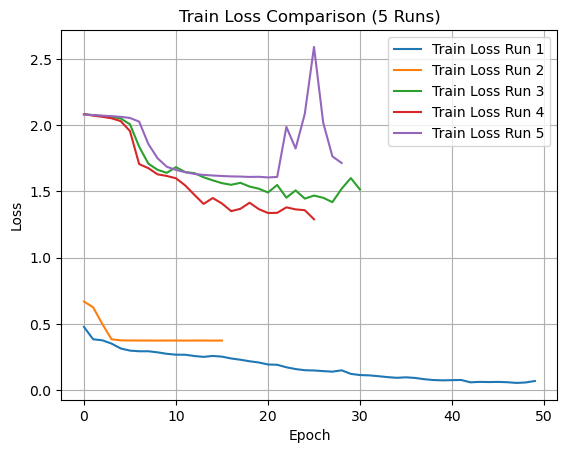

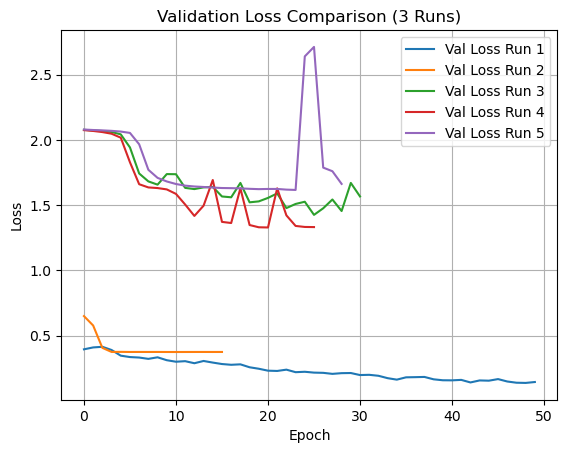

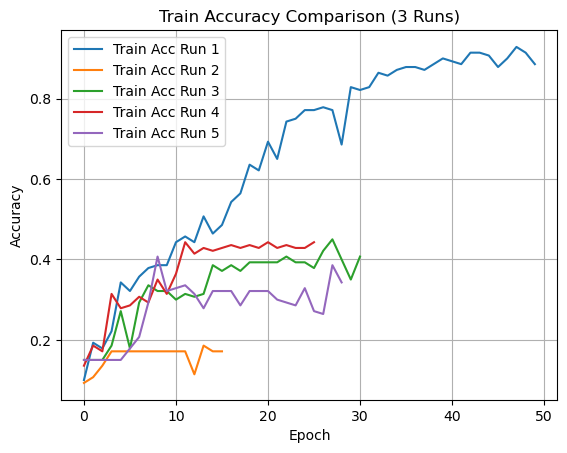

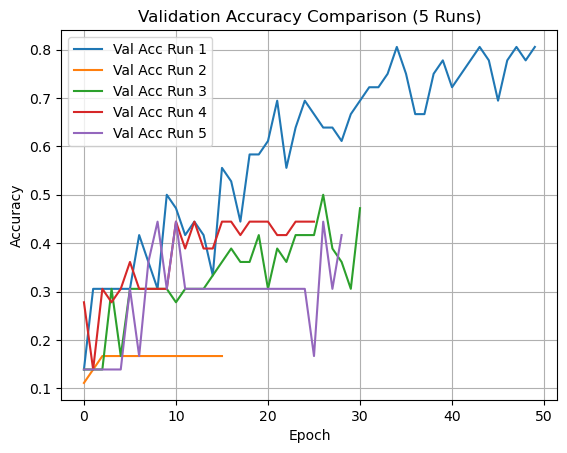

In [21]:

##SONUÇLARI GÖRSELLEŞTİRME
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DOSYA SUFFIX'LERİ
# -----------------------
suffixes = ["_1", "_2", "_3","_4", "_5"]

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# -----------------------
# LOAD DATA
# -----------------------
for s in suffixes:
    train_losses.append(np.load(f"new_train_loss{s}.npy"))
    val_losses.append(np.load(f"new_val_loss{s}.npy"))
    train_accs.append(np.load(f"new_train_acc{s}.npy"))
    val_accs.append(np.load(f"new_val_acc{s}.npy"))

# -----------------------
# TRAIN LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(train_losses):
    plt.plot(loss, label=f"Train Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison (5 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(val_losses):
    plt.plot(loss, label=f"Val Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# TRAIN ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(train_accs):
    plt.plot(acc, label=f"Train Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(val_accs):
    plt.plot(acc, label=f"Val Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison (5 Runs)")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRN(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, d_model)
        self.gate = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        gate = torch.sigmoid(self.gate(x))
        return self.layer_norm(gate * z + (1 - gate) * x)



class TFT(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_classes):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        self.encoder = nn.LSTM(
            d_model, d_model, batch_first=True
        )

        self.attention = nn.MultiheadAttention(
            d_model, num_heads, batch_first=True
        )

        self.grn = GRN(d_model)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        """
        x: (B, T, F)
        """
        x = self.embedding(x)
        enc_out, _ = self.encoder(x)

        attn_out, _ = self.attention(
            enc_out, enc_out, enc_out
        )

        fused = self.grn(attn_out)

        # (B, T, D) -> (B, D)
        pooled = self.pool(fused.transpose(1, 2)).squeeze(-1)

        logits = self.classifier(pooled)
        return logits


In [8]:
model_transform = TFT(input_dim=102, d_model=64, num_heads=2, num_classes=7)

criterion_tft = nn.CrossEntropyLoss()

optimizer_tft = torch.optim.Adam(
    model_transform.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_tft = torch.optim.lr_scheduler.StepLR(
    optimizer_tft, step_size=15, gamma=0.8
)

train_losses_tft, train_accs_tft, val_losses_tft, val_accs_tft = train_utils.train_multi_class_model(
    model_transform,
    train_loader,
    test_loader,
    loss=criterion_tft,
    optimizer=optimizer_tft,
    scheduler=scheduler_tft,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TFT"
)

np.save("before_train_loss_tft.npy", train_losses_tft)
np.save("before_train_acc_tft.npy", train_accs_tft)
np.save("before_val_loss_tft.npy", val_losses_tft)
np.save("before_val_acc_tft.npy", val_accs_tft)



Epoch [1/50]
Train Loss: 1.9983, Train Acc: 17.50%
Val Loss: 1.9326, Val Acc: 16.67%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/50]
Train Loss: 1.9466, Train Acc: 16.67%
Val Loss: 1.9226, Val Acc: 20.00%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/50]
Train Loss: 1.9015, Train Acc: 20.00%
Val Loss: 1.8800, Val Acc: 20.00%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/50]
Train Loss: 1.8815, Train Acc: 32.50%
Val Loss: 1.8454, Val Acc: 50.00%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/50]
Train Loss: 1.8088, Train Acc: 39.17%
Val Loss: 1.7407, Val Acc: 36.67%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/50]
Train Loss: 1.6672, Train Acc: 32.50%
Val Loss: 1.5312, Val Acc: 36.67%
Learning Rate: 0.000

In [9]:
class TFT_Classifier_V2(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_classes, dropout=0.2):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        # 🔥 CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        self.encoder = nn.LSTM(
            d_model, d_model, batch_first=True, dropout=dropout
        )

        self.attn1 = nn.MultiheadAttention(
            d_model, num_heads, batch_first=True, dropout=dropout
        )
        self.grn1 = GRN(d_model)

        self.attn2 = nn.MultiheadAttention(
            d_model, num_heads, batch_first=True, dropout=dropout
        )
        self.grn2 = GRN(d_model)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)

        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B, T, _ = x.shape

        x = self.embedding(x)

        # CLS token ekle
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)  # (B, T+1, D)

        enc_out, _ = self.encoder(x)

        attn_out, _ = self.attn1(enc_out, enc_out, enc_out)
        x = self.grn1(attn_out)

        attn_out, _ = self.attn2(x, x, x)
        x = self.grn2(attn_out)

        cls_out = x[:, 0]  # sadece CLS
        cls_out = self.dropout(cls_out)

        logits = self.classifier(cls_out)
        return logits


In [17]:
model_transform_2 = TFT_Classifier_V2(input_dim=102, d_model=64, num_heads=2, num_classes=7)

criterion_tft_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_tft_2 = torch.optim.Adam(
    model_transform_2.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_tft_2 = torch.optim.lr_scheduler.StepLR(
    optimizer_tft_2, step_size=15, gamma=0.8
)

train_losses_tft_2, train_accs_tft_2, val_losses_tft_2, val_accs_tft_2 = train_utils.train_multi_class_model(
    model_transform_2,
    train_loader,
    test_loader,
    loss=criterion_tft_2,
    optimizer=optimizer_tft_2,
    scheduler=scheduler_tft_2,
    epochs=100,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TFT_2"
)

np.save("before_train_loss_tft_2.npy", train_losses_tft_2)
np.save("before_train_acc_tft_2.npy", train_accs_tft_2)
np.save("before_val_loss_tft_2.npy", val_losses_tft_2)
np.save("before_val_acc_tft_2.npy", val_accs_tft_2)



Epoch [1/100]
Train Loss: 2.0899, Train Acc: 11.67%
Val Loss: 1.9448, Val Acc: 30.00%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/100]
Train Loss: 1.9688, Train Acc: 16.67%
Val Loss: 1.9383, Val Acc: 20.00%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/100]
Train Loss: 1.9559, Train Acc: 20.83%
Val Loss: 1.9049, Val Acc: 20.00%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/100]
Train Loss: 1.9165, Train Acc: 22.50%
Val Loss: 1.8680, Val Acc: 26.67%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/100]
Train Loss: 1.8738, Train Acc: 30.83%
Val Loss: 1.7786, Val Acc: 33.33%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/100]
Train Loss: 1.7470, Train Acc: 32.50%
Val Loss: 1.6464, Val Acc: 33.33%
Learning Rate:

In [3]:
from flask import Flask, request, jsonify
import cv2
import numpy as np
import torch
import mediapipe as mp
import os
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

@app.after_request
def after_request(response):
    response.headers.add('Access-Control-Allow-Origin', '*')
    response.headers.add('Access-Control-Allow-Headers', 'Content-Type,Authorization')
    response.headers.add('Access-Control-Allow-Methods', 'GET,PUT,POST,DELETE,OPTIONS')
    return response

@app.route('/')
def home():
    return jsonify({"status": "Flask çalışıyor!", "port": 5001})

class_names = {
    0: "squat",
    1: "pushup",
    2: "dag_tirmanis",
    3: "jumping_jack",
    #4: "lunge",
    4: "plank",
    5: "side_plank",
    6: "diz_cekme"
}
device = "cpu"

app_model=PoseTCN_2(input_size=102, num_classes=8)
app_model.load_state_dict(
    torch.load(
        "/Users/tahay/Documents/Bitirme-KazımHanbay/bitirme0/models/TCN_One_Hot_NOLunge_best.pth",
        map_location=device
    )
)
app_model.eval()

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

sequence_length = 200

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

@app.route('/predict', methods=['POST', 'OPTIONS'])
def predict():
    if request.method == 'OPTIONS':
        return '', 204

    if 'video' not in request.files:
        return jsonify({"error": "Video file missing"}), 400

    video_file = request.files['video']
    video_path = "temp_video.mp4"
    video_file.save(video_path)

    cap = cv2.VideoCapture(video_path)
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 🔹 1️⃣ 33 landmark × 3 = 99
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                lm_data = landmarks[lm]
                keypoints.extend([lm_data.x, lm_data.y, lm_data.z])

            # 🔹 2️⃣ Açılar
            ls = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
            lh = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            lk = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
            la = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]
            lf = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]

            hip_angle = calculate_angle(
                [ls.x, ls.y, ls.z],
                [lh.x, lh.y, lh.z],
                [lk.x, lk.y, lk.z]
            )

            knee_angle = calculate_angle(
                [lh.x, lh.y, lh.z],
                [lk.x, lk.y, lk.z],
                [la.x, la.y, la.z]
            )

            ankle_angle = calculate_angle(
                [lk.x, lk.y, lk.z],
                [la.x, la.y, la.z],
                [lf.x, lf.y, lf.z]
            )

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

    cap.release()
    os.remove(video_path)

    # =====================
    # PAD / TRIM → 200 FRAME
    # =====================
    if len(frames_data) < sequence_length:
        last_frame = frames_data[-1] if frames_data else [0] * 102
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data[:sequence_length], dtype=np.float32)

    # =====================
    # NORMALIZE (TRAIN İLE AYNI)
    # =====================
    max_val = np.max(np.abs(frames_data))
    if max_val > 0:
        frames_data = frames_data / max_val

    # =====================
    # MODEL INFERENCE
    # =====================
    frames_tensor = torch.from_numpy(frames_data).unsqueeze(0)  # (1, 200, 102)

    with torch.no_grad():
        logits = app_model(frames_tensor)

    pred_id = torch.argmax(logits, dim=1).item()
    pred_name = class_names[pred_id]

    return jsonify({
        "prediction_id": pred_id,
        "prediction_name": pred_name
    })



if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001, debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


I0000 00:00:1766470221.574499 4508876 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://192.168.1.37:5001
Press CTRL+C to quit
W0000 00:00:1766470221.676644 4511043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766470221.693348 4511043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766470267.126394 4511048 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
127.0.0.1 - - [23/Dec/2025 09:11:08] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Dec/2025 09:43:09] "POST /predict HTTP/1.